In [109]:
#%pip install numpy
#%pip install pandas
#%pip install matplotlib
#%pip install scikit-learn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn as sk

In [110]:
summary = pd.read_csv("garmin_edge_820/summary.csv",sep=";")   
details = pd.read_csv("garmin_edge_820/4557226804_ACTIVITY_data.csv", sep=";")
details =  details.drop(['left_power_phase[degrees]', 
                  'left_power_phase_peak[degrees]', 
                  'right_power_phase[degrees]', 
                  'right_power_phase_peak[degrees]', 
                  'temperature[C]','left_right_balance','left_pco[mm]','right_pco[mm]'], axis=1)

In [111]:
details['time'] = pd.to_datetime(details.pop('timestamp[s]'), unit='s').dt.time
details.set_index("time", inplace=True)

In [112]:
hr_zones = [(0, 128), (129, 146), (147, 156), (157, 165), (166, 174), (175, 179), (180, float('inf'))]
power_zones = [(0, 157), (158, 186), (187, 200), (201, 218), (219, 247), (248, 287), (288, float('inf'))]
# funzione che calcola le zone di frequenza cardiaca dato il battito in input

def get_zone(rate, zones):
    for zone, (lower, upper) in enumerate(zones, start=1):
        if lower <= rate <= upper:
            return zone

In [113]:
details['hr_zone'] = details['heart_rate[bpm]'].apply(get_zone, zones=hr_zones)
details['pwr_zone'] = details['power[watts]'].apply(get_zone, zones=power_zones)

In [114]:
details['time_since_start'] = 1
details['time_since_start'] = details['time_since_start'].cumsum().sub(1)

In [115]:
# Calcola la differenza di altitudine tra le righe adiacenti
details['altitude_diff'] = details['altitude[m]'] - details['altitude[m]'].shift(1)
details['distance_diff'] = details['distance[m]'] - details['distance[m]'].shift(1)
details[['altitude_diff', 'distance_diff']] = details[['altitude_diff', 'distance_diff']].fillna(0)

# Calcola la percentuale di pendenza
details['slope_percent'] = np.where(details['distance_diff'] == 0, 0, details['altitude_diff'] / details['distance_diff'] * 100)

In [116]:
details.dtypes

distance[m]                        float64
accumulated_power[watts]             int64
altitude[m]                        float64
speed[m/s]                         float64
power[watts]                         int64
heart_rate[bpm]                      int64
cadence[rpm]                         int64
temperature[C]                       int64
left_right_balance                   int64
left_pco[mm]                         int64
right_pco[mm]                        int64
left_power_phase[degrees]           object
left_power_phase_peak[degrees]      object
right_power_phase[degrees]          object
right_power_phase_peak[degrees]     object
hr_zone                              int64
pwr_zone                             int64
time_since_start                     int64
altitude_diff                      float64
distance_diff                      float64
slope_percent                      float64
dtype: object

In [117]:
details.isna().sum()

distance[m]                        0
accumulated_power[watts]           0
altitude[m]                        0
speed[m/s]                         1
power[watts]                       0
heart_rate[bpm]                    0
cadence[rpm]                       0
temperature[C]                     0
left_right_balance                 0
left_pco[mm]                       0
right_pco[mm]                      0
left_power_phase[degrees]          0
left_power_phase_peak[degrees]     0
right_power_phase[degrees]         0
right_power_phase_peak[degrees]    0
hr_zone                            0
pwr_zone                           0
time_since_start                   0
altitude_diff                      0
distance_diff                      0
slope_percent                      0
dtype: int64

In [118]:
details['speed[m/s]'] = details['speed[m/s]'].fillna(details['speed[m/s]'].mean()) 

### Data Visualization

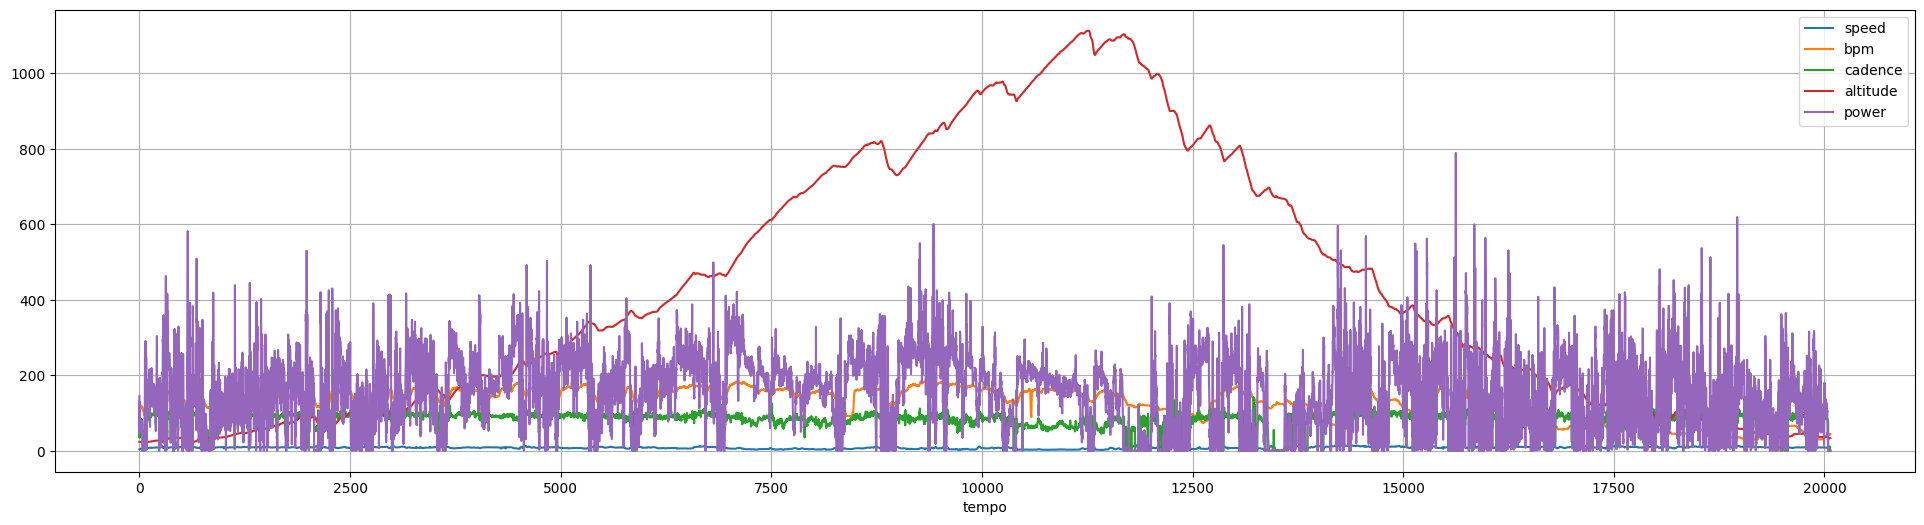

In [119]:
plt.figure(figsize=(24, 6))
plt.plot(details['time_since_start'], details['speed[m/s]'], label="speed")
plt.plot(details['time_since_start'], details['heart_rate[bpm]'], label="bpm")
plt.plot(details['time_since_start'], details['cadence[rpm]'], label="cadence")
plt.plot(details['time_since_start'], details['altitude[m]'], label="altitude")
plt.plot(details['time_since_start'], details['power[watts]'], label="power")
plt.xlabel("tempo")
plt.legend()
plt.grid(True)
plt.show()

# Models

## Previsione potenza

In [ ]:
# Seleziona le colonne che saranno utilizzate come feature per la predizione delle calorie
features = details.columns.drop(['distance[m]','heart_rate[bpm]','altitude_diff',	'distance_diff'	,'slope_percent', 'time_since_start','hr_zone','pwr_zone','accumulated_power[watts]','altitude[m]'])

# Seleziona la colonna delle calorie come target
target = 'heart_rate[bpm]'  # Assumi che la colonna delle calorie bruciate si chiami 'calories_burned'

# Dividi il dataset in set di addestramento e set di test
X_train, X_test, y_train, y_test = train_test_split(details[features], details[target], test_size=0.2, random_state=42)

# Crea un'istanza del modello di regressione lineare
model = Pipeline([
    ("poly", PolynomialFeatures(degree=5, include_bias=False)),
    ("linear", LinearRegression(n_jobs=-1))
])

# Addestra il modello sui dati di addestramento
model.fit(X_train, y_train)

# Effettua la predizione sul set di test
y_pred = model.predict(X_test)

# Calcola l'errore medio quadratico
mse = mean_squared_error(y_test, y_pred)
print("Errore medio quadratico:", mse)

# Ora puoi utilizzare il modello addestrato per predire la potenza per nuovi dati
new_data = pd.DataFrame([[4,140,60]], columns=features)
watts_pred = model.predict(new_data)
print("Potenza predetta:", watts_pred)

## Previsione battito

#### Regressione lineare

In [120]:
X = details.drop('heart_rate[bpm]',axis=1)
y = details['heart_rate[bpm]']


In [121]:
from sklearn.metrics import mean_squared_error, r2_score

# definisco l'errore relativo
def relative_error(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true))

def print_eval(X, y, model):
    preds = model.predict(X)
    mse = mean_squared_error(y, preds)
    re = relative_error(y, preds)
    r2 = r2_score(y, preds)
    print(f"   Mean squared error: {mse:.5}")
    print(f"       Relative error: {re:.5%}")
    print(f"R-squared coefficient: {r2:.5}")

In [122]:
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

In [123]:
from sklearn.linear_model import LinearRegression
lrm = LinearRegression()
lrm.fit(X_train, y_train)
print_eval(X_val, y_val, lrm)

   Mean squared error: 183.03
       Relative error: 11.03527%
R-squared coefficient: 0.88208


In [124]:
from sklearn.linear_model import Lasso
lsm = Lasso(alpha=0.3)
lsm.fit(X_train, y_train)
print_eval(X_val, y_val, lsm)

   Mean squared error: 183.98
       Relative error: 11.06330%
R-squared coefficient: 0.88146


C:\Users\pnmat\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.586e+06, tolerance: 2.546e+03
  coef_, l1_reg, l2_reg, X, y, max_iter, tol, rng, random, positive


In [125]:
from sklearn.linear_model import Ridge
rrm = Ridge(alpha=0.5)
rrm.fit(X_train, y_train)
print_eval(X_val, y_val, rrm)

   Mean squared error: 183.03
       Relative error: 11.03530%
R-squared coefficient: 0.88208


In [126]:
from sklearn.linear_model import ElasticNet
enm = ElasticNet(alpha=0.1, l1_ratio=0.5)
enm.fit(X_train, y_train)
print_eval(X_val, y_val, enm)

   Mean squared error: 184.44
       Relative error: 11.08016%
R-squared coefficient: 0.88117


C:\Users\pnmat\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.610e+06, tolerance: 2.546e+03
  coef_, l1_reg, l2_reg, X, y, max_iter, tol, rng, random, positive


In [127]:
pd.DataFrame({
    "linear": lrm.coef_,
    "ridge": rrm.coef_,
    "lasso": lsm.coef_
}, index=X_train.columns)

,linear,ridge,lasso
distance[m],-0.002392,-0.002392,-0.002187
accumulated_power[watts],0.000130,0.000130,0.000107
altitude[m],-0.030684,-0.030684,-0.022686
speed[m/s],1.364711,1.364583,1.013341
power[watts],0.011910,0.011908,0.002125
cadence[rpm],-0.041070,-0.041062,-0.027279
temperature[C],2.419016,2.419036,2.312895
left_right_balance,0.008089,0.008091,0.007438
left_pco[mm],0.011945,0.011956,0.001202
right_pco[mm],-0.177860,-0.177864,-0.153518


#### Regressione Polinomiale

In [128]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline

In [129]:
lrm_poly = Pipeline([
    ("poly", PolynomialFeatures(degree=4, include_bias=False)),
    ("linear", LinearRegression())
])
lrm_poly.fit(X_train, y_train)
print_eval(X_val, y_val, lrm_poly)

   Mean squared error: 54.066
       Relative error: 5.06173%
R-squared coefficient: 0.96517


In [130]:
lsm_poly = Pipeline([
    ("poly", PolynomialFeatures(degree=2, include_bias=False)),
    ("lasso", Lasso(alpha=0.7)) 
])
lsm_poly.fit(X_train, y_train)
print_eval(X_val, y_val, lsm_poly)

   Mean squared error: 92.164
       Relative error: 7.43713%
R-squared coefficient: 0.94062


C:\Users\pnmat\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.519e+05, tolerance: 2.546e+03
  coef_, l1_reg, l2_reg, X, y, max_iter, tol, rng, random, positive


In [131]:
rrm_poly = Pipeline([
    ("poly", PolynomialFeatures(degree=3, include_bias=False)),
    ("ridge", Ridge(alpha=1))
])
rrm_poly.fit(X_train, y_train)
print_eval(X_val, y_val, rrm_poly)

   Mean squared error: 1.9345e+06
       Relative error: 40.24717%
R-squared coefficient: -1245.4


C:\Users\pnmat\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_ridge.py:157: LinAlgWarning: Ill-conditioned matrix (rcond=6.01368e-43): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True, overwrite_a=True).T


In [132]:
enm_poly = Pipeline([
    ("poly", PolynomialFeatures(degree=2, include_bias=False)),
    ("elasticnet", ElasticNet(alpha=0.1, l1_ratio=0.5))
])
enm_poly.fit(X_train, y_train)
print_eval(X_val, y_val, enm_poly)

   Mean squared error: 90.685
       Relative error: 7.35120%
R-squared coefficient: 0.94157


C:\Users\pnmat\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.136e+05, tolerance: 2.546e+03
  coef_, l1_reg, l2_reg, X, y, max_iter, tol, rng, random, positive


#### Regressione polinomiale con standardizzazione

In [133]:
from sklearn.preprocessing import StandardScaler

lrm_poly_std = Pipeline([
    ("poly", PolynomialFeatures(degree=3, include_bias=False)),
    ("std", StandardScaler()),
    ("linear", LinearRegression())
])
lrm_poly_std.fit(X_train, y_train)
print_eval(X_val, y_val, lrm_poly_std)

   Mean squared error: 5.1699e+06
       Relative error: 69.09474%
R-squared coefficient: -3329.8


In [134]:
lsm_poly_std = Pipeline([
    ("poly", PolynomialFeatures(degree=3, include_bias=False)),
    ("std", StandardScaler()),
    ("lasso", Lasso(alpha=0.7))
])
lsm_poly_std.fit(X_train, y_train)
print_eval(X_val, y_val, lsm_poly_std)

   Mean squared error: 114.8
       Relative error: 8.56718%
R-squared coefficient: 0.92604


In [135]:
rrm_poly_std = Pipeline([
    ("poly", PolynomialFeatures(degree=3, include_bias=False)),
    ("std", StandardScaler()),
    ("ridge", Ridge(alpha=1))
])
rrm_poly_std.fit(X_train, y_train)
print_eval(X_val, y_val, rrm_poly_std)

   Mean squared error: 58.805
       Relative error: 5.77012%
R-squared coefficient: 0.96211


In [136]:
enm_poly_std = Pipeline([
    ("poly", PolynomialFeatures(degree=3, include_bias=False)),
    ("std", StandardScaler()),
    ("elasticnet", ElasticNet(alpha=0.1, l1_ratio=0.5))
])
enm_poly_std.fit(X_train, y_train)
print_eval(X_val, y_val, enm_poly_std)

   Mean squared error: 90.343
       Relative error: 7.38392%
R-squared coefficient: 0.94179


C:\Users\pnmat\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.469e+05, tolerance: 2.546e+03
  coef_, l1_reg, l2_reg, X, y, max_iter, tol, rng, random, positive


#### Regressione con funzioni kernel

In [137]:
from sklearn.kernel_ridge import KernelRidge

In [138]:
krm_poly = Pipeline([
    ("std", StandardScaler()),
    ("kernel", KernelRidge(alpha=20, kernel="poly", degree=6))
])
krm_poly.fit(X_train, y_train)
print_eval(X_val, y_val, krm_poly)

   Mean squared error: 9391.0
       Relative error: 8.77653%
R-squared coefficient: -5.0503


In [139]:
krm_rbf = Pipeline([
    ("std", StandardScaler()),
    ("kernel", KernelRidge(alpha=0.1, kernel="rbf", gamma=0.1))
])
krm_rbf.fit(X_train, y_train)
print_eval(X_val, y_val, krm_rbf)

   Mean squared error: 71.716
       Relative error: 5.16247%
R-squared coefficient: 0.9538


#### Cross validation

In [140]:
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_validate

kf = KFold(n_splits=5, shuffle=True, random_state=42)

In [141]:
pd.DataFrame(cross_validate(lrm, X, y, cv=kf, return_train_score=True)).describe().loc[["mean", "std"]]

,fit_time,score_time,test_score,train_score
mean,0.040204,0.006896,0.882921,0.883312
std,0.031898,0.004195,0.004357,0.001090


In [142]:
pd.DataFrame(cross_validate(lrm_poly, X, y, cv=kf, return_train_score=True)).describe().loc[["mean", "std"]]